In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import csv

In [ ]:
os.getcwd()

'/content'

In [ ]:

FER2013_WIDTH = 48
FER2013_HEIGHT = 48

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data["emotion"].value_counts(sort=True)

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [ ]:
#Pre Procesado de la Data
fer_alto = 48
fer_ancho= 48
Emotions =["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def fer2013_show_instance(index):
    """Shows the image and the emotion label of the index's instance."""
    image = np.reshape(data.at[index, "pixels"].split(" "), (fer_ancho, fer_alto)).astype("float")
    image -= np.mean(image)
    image /= np.std(image)
    print(Emotions[data.at[index, "emotion"]])
    plt.imshow(image, cmap="gray")

Happy


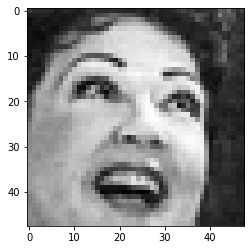

In [ ]:
fer2013_show_instance(np.random.randint(0,len(data)))

In [ ]:
def fer2013_to_X():
    #Trasnsformamos a un array 3 dimensional

    X = []
    pixels_list = data["pixels"].values

    for pixels in pixels_list:
        single_image = np.reshape(pixels.split(" "), (fer_ancho,fer_alto)).astype("float")
        X.append(single_image)

    # Convert list to 4D array:
    X = np.expand_dims(np.array(X), -1)

    # Normalize image data:
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)

    return X

In [ ]:
X = fer2013_to_X()
X.shape

(28709, 48, 48, 1)

In [ ]:
Y = np.array(data['emotion'])
Y.shape

(28709,)

In [ ]:
# Importamos clasificadores y metricas de sklearn
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Dividimos la data en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.2, random_state=2)
X_train, X_valid = X_train/255.0, X_valid/255.0
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((22967, 48, 48, 1), (5742, 48, 48, 1), (22967,), (5742,))

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version: 2.8.2


In [ ]:
cnn_model = Sequential()

# 1st convolution layer
cnn_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 2nd convolution layer
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 3rd convolution layer
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 4th convolution layer
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# Fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                        

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 30s 47ms/step - loss: 1.8816 - accuracy: 0.2310 - val_loss: 1.8286 - val_accuracy: 0.2513 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 15s 41ms/step - loss: 1.7481 - accuracy: 0.2800 - val_loss: 1.6709 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 15s 41ms/step - loss: 1.6014 - accuracy: 0.3563 - val_loss: 1.4744 - val_accuracy: 0.4145 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 15s 42ms/step - loss: 1.4669 - accuracy: 0.4287 - val_loss: 1.4415 - val_accuracy: 0.4152 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 15s 42ms/step - loss: 1.3869 - accuracy: 0.4681 - val_loss: 1.3533 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 15s 43ms/step - loss: 1.3189 - accuracy: 0.4977 - val_loss: 1.2440 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 7/100
359/359 [==============================]

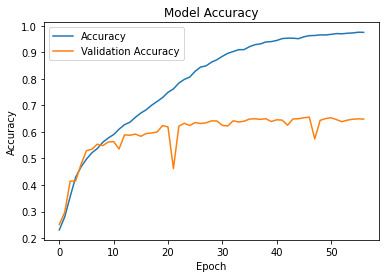

In [ ]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
# Evaluate the model before improvement
_, score_before_improvement = cnn_model.evaluate(X_valid, y_valid)
print('Score before improvement: {}'.format(score_before_improvement))

180/180 [==============================] - 2s 10ms/step - loss: 2.2962 - accuracy: 0.6484
Score before improvement: 0.6483803391456604


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns],
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

In [ ]:
predictions = cnn_model.predict(X_valid)
y_pred = np.argmax(predictions, axis=1)

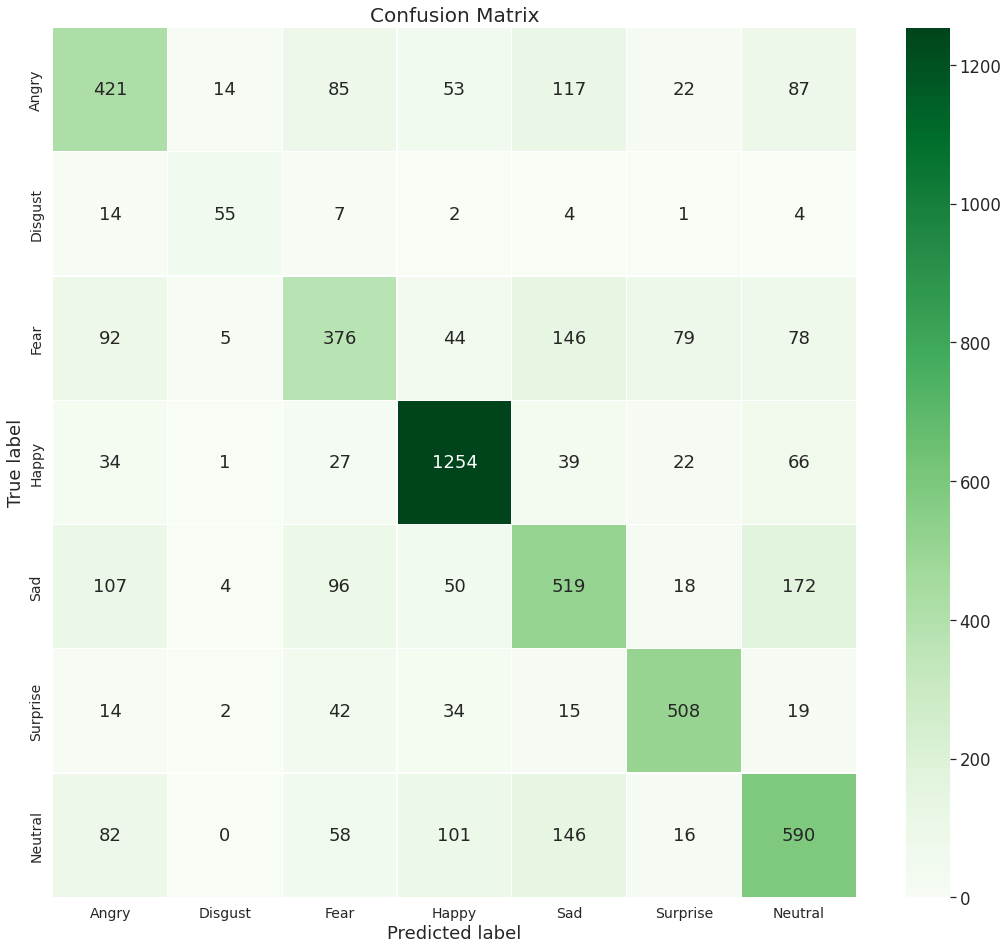

In [ ]:
create_confmat(y_valid,y_pred,Emotions)

In [ ]:
modelo_vgg=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
   input_shape= (48,48,3)
)


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
modelo_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
!unzip '/content/archive.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
 

In [ ]:
img = cv2.imread('/content/train/surprise/Training_69082438.jpg')
dimensions = img.shape
print(dimensions)

(48, 48, 3)


In [ ]:
train_img_datagen = ImageDataGenerator(rescale=1./255)
val_img_datagen= ImageDataGenerator(rescale=1./255)
batch_size= 64

In [ ]:


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    labels = np.zeros(shape=(sample_count, 7))

    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory,
        target_size=(48, 48),
        batch_size = batch_size,
        class_mode='categorical')

    i = 0

    print('Entering for loop...');


    for inputs_batch, labels_batch in generator:
        features_batch = modelo_vgg.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels



In [ ]:
train_features, train_labels = extract_features('/content/train', 28709)
validation_features, validation_labels = extract_features('/content/test', 7178)


Found 28709 images belonging to 7 classes.
Entering for loop...
Found 7178 images belonging to 7 classes.
Entering for loop...


In [ ]:
train_atributos = np.reshape(train_features, (28709, 1* 1* 512))
val_atributos = np.reshape(validation_features, (7178, 1* 1 * 512))

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

In [ ]:
model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

In [ ]:

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 2048)              1050624   
                                                                 
 dropout_28 (Dropout)        (None, 2048)              0         
                                                                 
 dense_39 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 128)               65664     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 7)               

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
history = model.fit(train_atributos, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_atributos, validation_labels))

Epoch 1/50
898/898 [==============================] - 4s 4ms/step - loss: 1.7564 - acc: 0.2932 - val_loss: 1.6539 - val_acc: 0.3600
Epoch 2/50
898/898 [==============================] - 3s 4ms/step - loss: 1.6666 - acc: 0.3478 - val_loss: 1.5977 - val_acc: 0.3802
Epoch 3/50
898/898 [==============================] - 3s 4ms/step - loss: 1.6387 - acc: 0.3625 - val_loss: 1.5818 - val_acc: 0.3742
Epoch 4/50
898/898 [==============================] - 3s 4ms/step - loss: 1.6166 - acc: 0.3710 - val_loss: 1.5604 - val_acc: 0.3944
Epoch 5/50
898/898 [==============================] - 3s 4ms/step - loss: 1.6004 - acc: 0.3775 - val_loss: 1.5571 - val_acc: 0.3938
Epoch 6/50
898/898 [==============================] - 3s 4ms/step - loss: 1.5857 - acc: 0.3841 - val_loss: 1.5591 - val_acc: 0.3989
Epoch 7/50
898/898 [==============================] - 3s 4ms/step - loss: 1.5733 - acc: 0.3900 - val_loss: 1.5340 - val_acc: 0.4132
Epoch 8/50
898/898 [==============================] - 3s 4ms/step - loss: 1.

In [ ]:
import matplotlib.pyplot as plt

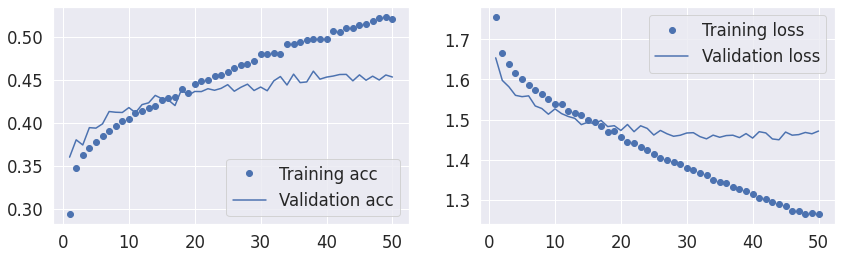

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_1_val = val_acc[-1]
print("Validation Accuracy: ", model_1_val)


Validation Accuracy:  0.453468918800354


In [ ]:
prediccion = model.predict(val_atributos)
y_pred2 = np.argmax(prediccion, axis=1)

In [ ]:
y_val= validation_labels.argmax(1)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

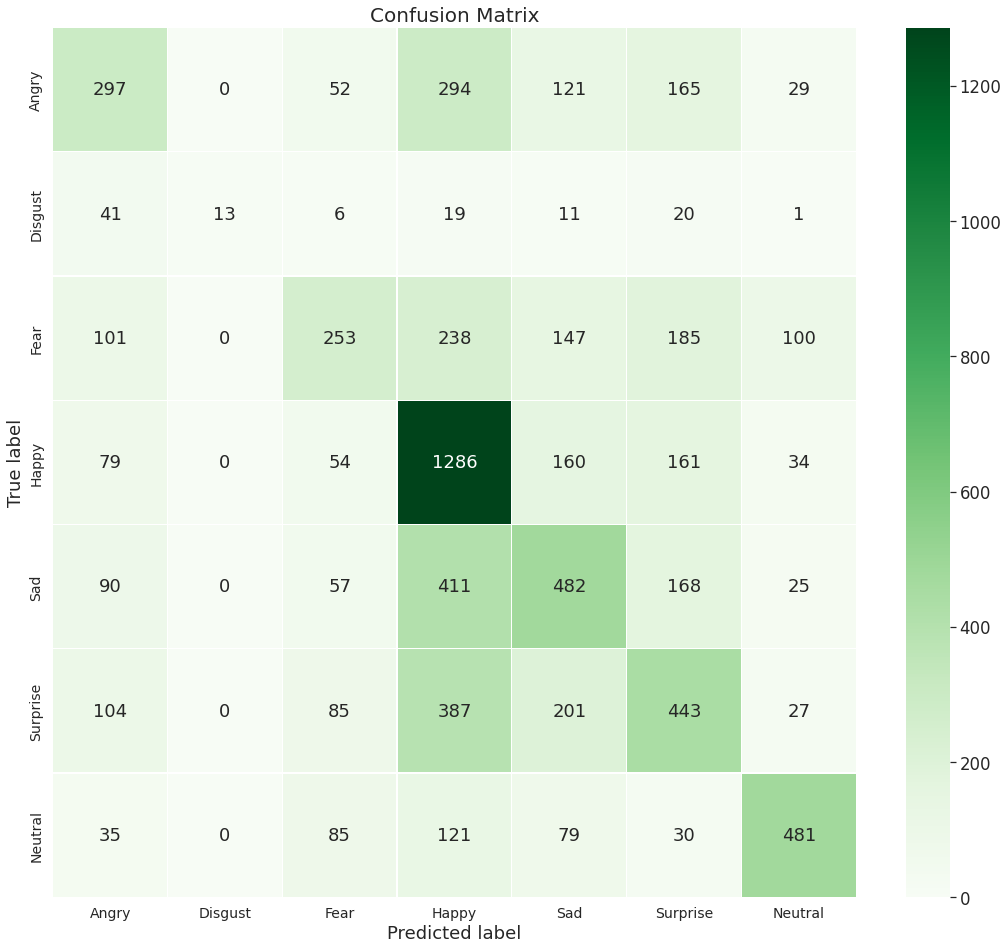

In [ ]:
create_confmat(y_val,y_pred2,Emotions)

In [ ]:
#Extraccion de Atributos con Data Augmentation

model2 = models.Sequential()
model2.add(modelo_vgg)
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(7, activation='softmax'))


In [ ]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 512)               262656    
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 128)               65664     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 7)               

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(48, 48),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(48, 48),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=2e-5)

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [ ]:
history = model2.fit_generator(
          train_generator,
          epochs=30,
          validation_data=validation_generator)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



449/449 [==============================] - 41s 88ms/step - loss: 1.2083 - acc: 0.5622 - val_loss: 0.9992 - val_acc: 0.6383
Epoch 2/30
449/449 [==============================] - 43s 96ms/step - loss: 0.9966 - acc: 0.6492 - val_loss: 1.0232 - val_acc: 0.6375
Epoch 3/30
449/449 [==============================] - 39s 87ms/step - loss: 0.9626 - acc: 0.6608 - val_loss: 0.9927 - val_acc: 0.6421
Epoch 4/30
449/449 [==============================] - 39s 87ms/step - loss: 0.9344 - acc: 0.6676 - val_loss: 0.9829 - val_acc: 0.6488
Epoch 5/30
449/449 [==============================] - 41s 91ms/step - loss: 0.9151 - acc: 0.6731 - val_loss: 0.9876 - val_acc: 0.6556
Epoch 6/30
449/449 [==============================] - 39s 87ms/step - loss: 0.8994 - acc: 0.6786 - val_loss: 1.0067 - val_acc: 0.6495
Epoch 7/30
449/449 [==============================] - 40s 88ms/step - loss: 0.8772 - acc: 0.6879 - val_loss: 0.9633 - val_acc: 0.6566
Epoch 8/30
449/449 [==============================] - 39s 87ms/step - los

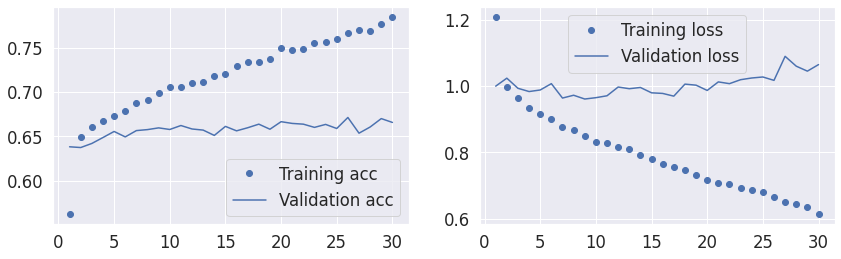

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

Validation Accuracy:  0.6657843589782715


In [ ]:
validation_generator.reset()
y_pred3 = model2.predict_generator(validation_generator)
y_pred3 = y_pred3.argmax(-1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
y_val2 = validation_generator.classes

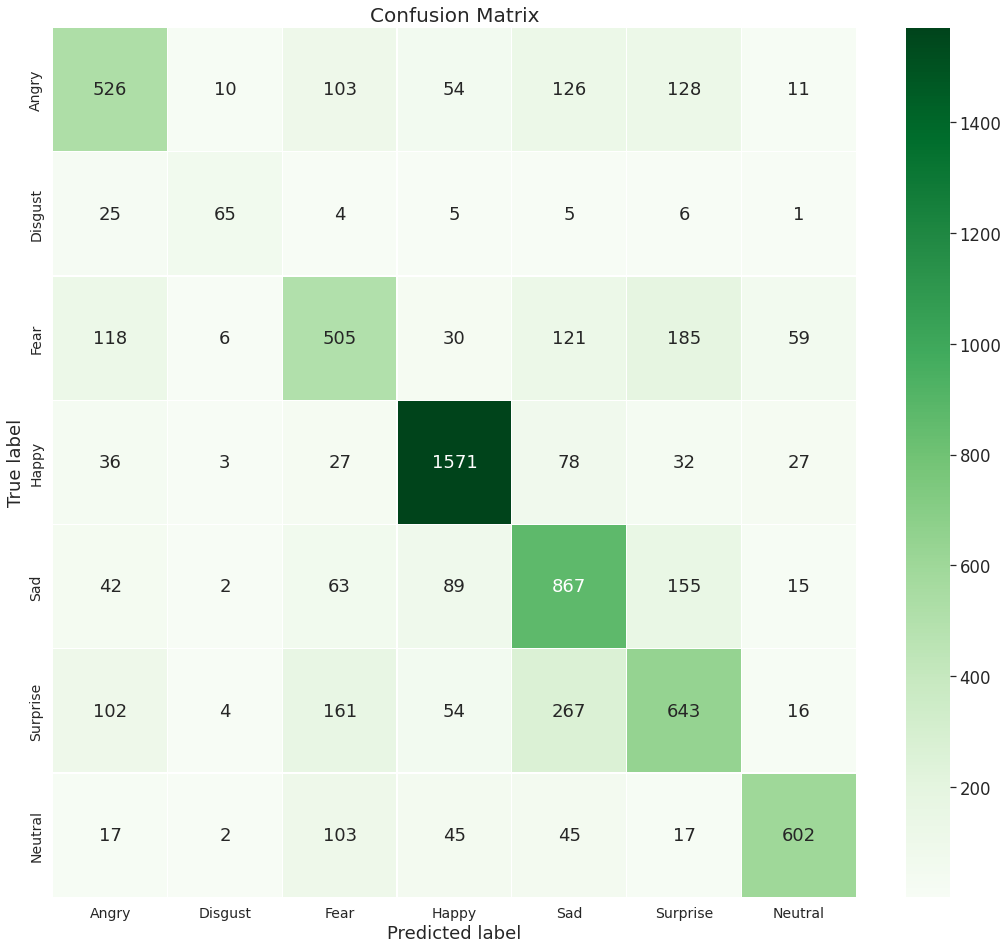

In [ ]:
create_confmat(y_val2,y_pred3,Emotions)